# 1. Import data and libraries

In [1]:
# Import the necessary libraries
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt
import numpy as np

# Read data from csv file
df1 = pd.read_csv('ETH-BTC.csv')
df1.head()

,Timestamp,Open,High,Low,Close
0,1529020800000,0.078281,0.078392,0.078250,0.078252
1,1529020860000,0.078266,0.078375,0.078266,0.078351
2,1529020920000,0.078372,0.078411,0.078337,0.078348
3,1529020980000,0.078400,0.078411,0.078340,0.078411
4,1529021040000,0.078411,0.078456,0.078340,0.078441


### Covert the date to minte data 

In [2]:
df1 = df1.set_index('Timestamp')
df1.index = pd.to_datetime(df1.index, unit='ms')

# Specify all the OHLC data to be numeric
df1 = df1.apply(pd.to_numeric)
df1.head()

,Open,High,Low,Close
Timestamp,,,,
2018-06-15 00:00:00,0.078281,0.078392,0.078250,0.078252
2018-06-15 00:01:00,0.078266,0.078375,0.078266,0.078351
2018-06-15 00:02:00,0.078372,0.078411,0.078337,0.078348
2018-06-15 00:03:00,0.078400,0.078411,0.078340,0.078411
2018-06-15 00:04:00,0.078411,0.078456,0.078340,0.078441


### Visualize the Close price

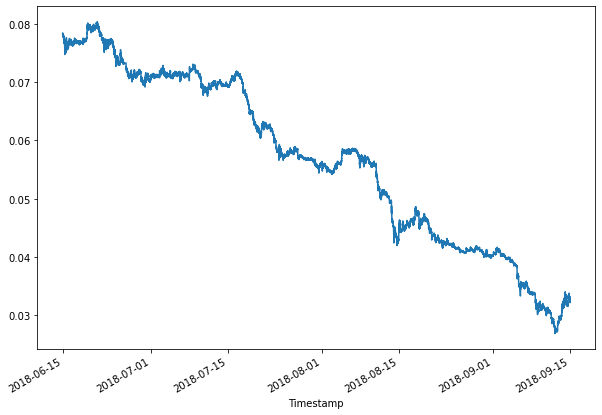

In [4]:
df1.Close.plot(figsize=(10, 7))
plt.show()

# 2. Compute the RSI and Aroon indicators for the Price series

In [5]:
# We use tp as the variable to denote the look back time period for indicators
tp = 14

In [6]:
# We calculate the RSI using the TabLib library and close prices
df1['RSI'] = ta.RSI(df1.Close.values, timeperiod=tp)

In [7]:
df1['AroonDown'], df1['AroonUp'] = ta.AROON(
    df1.High.values, df1.Low.values, timeperiod=tp)

In [8]:
df1 = df1.dropna()
df1.head()

,Open,High,Low,Close,RSI,AroonDown,AroonUp
Timestamp,,,,,,,
2018-06-15 00:14:00,0.078331,0.078427,0.078331,0.078352,58.417508,0.000000,28.571429
2018-06-15 00:15:00,0.078349,0.078431,0.078327,0.078358,58.864976,0.000000,21.428571
2018-06-15 00:16:00,0.078358,0.078437,0.078292,0.078390,61.259397,100.000000,14.285714
2018-06-15 00:17:00,0.078391,0.078437,0.078332,0.078344,56.195521,92.857143,7.142857
2018-06-15 00:18:00,0.078426,0.078437,0.078331,0.078356,57.189705,85.714286,0.000000


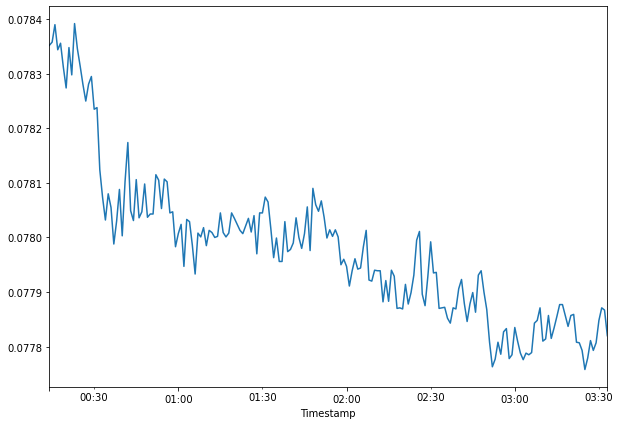

In [9]:
df1.Close.head(200).plot(figsize=(10, 7))
plt.show()

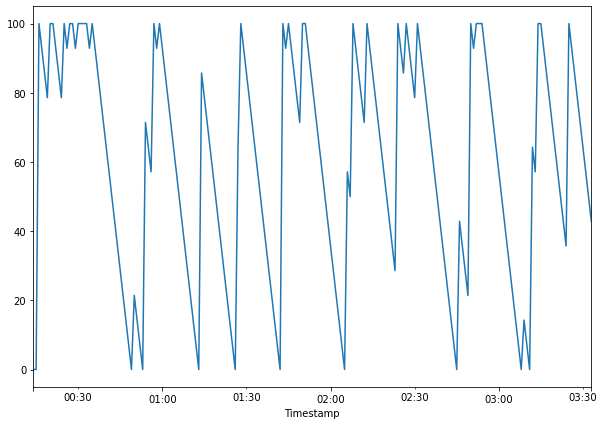

In [10]:
df1['AroonDown'].head(200).plot(figsize=(10, 7))
plt.show()

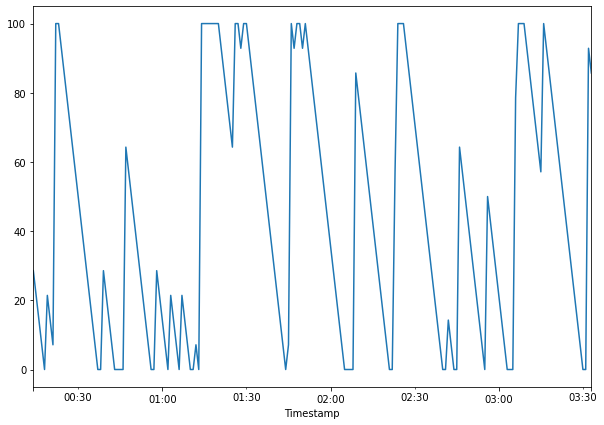

In [11]:
df1['AroonUp'].head(200).plot(figsize=(10, 7))
plt.show()

# 3. Compute the Aroon Values for the RSI

In [12]:
df1['AroonDownRSI'], df1['AroonUpRSI'] = ta.AROON(
    df1.RSI.values, df1.RSI.values, timeperiod=tp)

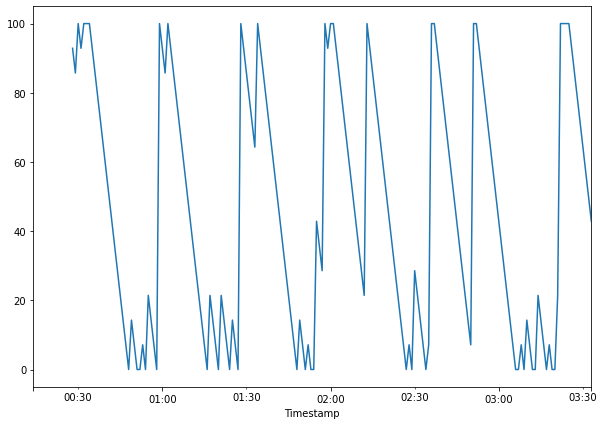

In [13]:
df1['AroonDownRSI'].head(200).plot(figsize=(10, 7))
plt.show()

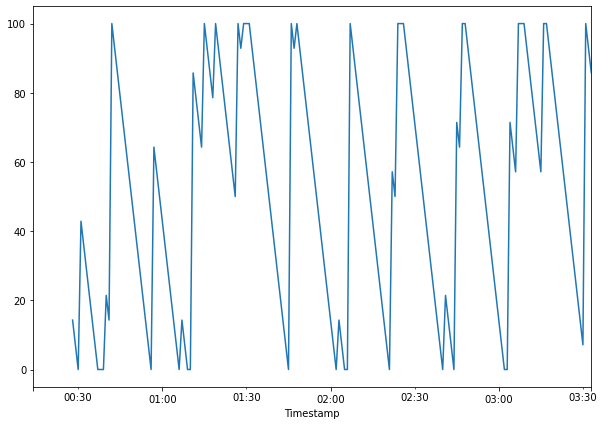

In [14]:
df1['AroonUpRSI'].head(200).plot(figsize=(10, 7))
plt.show()

# 4. Calculate the UpSpread and DownSpread

In [15]:
df1['UpSpread'] = df1.AroonUp - df1.AroonUpRSI

In [16]:
df1['DownSpread'] = df1.AroonDown - df1.AroonDownRSI

In [17]:
df1['Sellsignal'] = 0
df1['Buysignal'] = 0

# Set a Threshold value for the Spread. Here we used the variable 't' to denote that.
t = 75

### Visualize the UpSpread with the threshold value

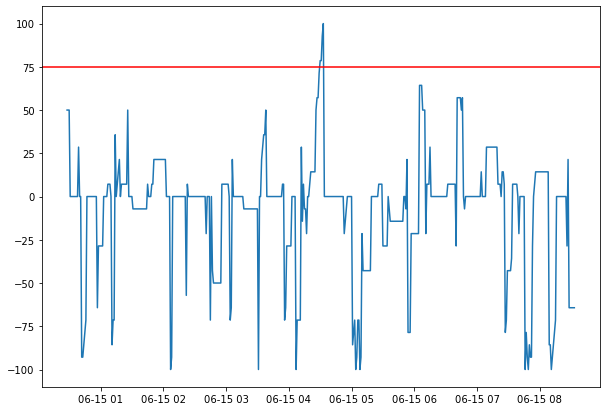

In [18]:
plt.figure(figsize=(10, 7))
plt.plot((df1.UpSpread).head(500))
plt.axhline(t, color='r')
plt.show()

# 5. Generate the Trading signal

### Generate the Buy signals

In [24]:
# We will buy wherever the UpSpread crosses the threshold value 't'
df1.Buysignal = np.where(df1.UpSpread > t, 1, df1.Buysignal)

### Generate the Sell Signals

In [25]:
# We will buy wherever the DownSpread crosses the threshold value 't'
df1.Sellsignal = np.where(df1.DownSpread > t, - 1, df1.Sellsignal)

In [26]:
# Check the total number of sell signals
df1.Sellsignal.sum()

-3701

In [27]:
# Check the total number of buy signals
df1.Buysignal.sum()

3190

In [28]:
# Combine the two signals to create a signal column
# This signal is generated once the one minute candle closes
df1 = df1.assign(Signal=df1.Sellsignal + df1.Buysignal)

In [29]:
df1['TradeSignal'] = 0
df1.TradeSignal = df1.Signal.shift(1)

# 6 Compute the cumulative strategy return

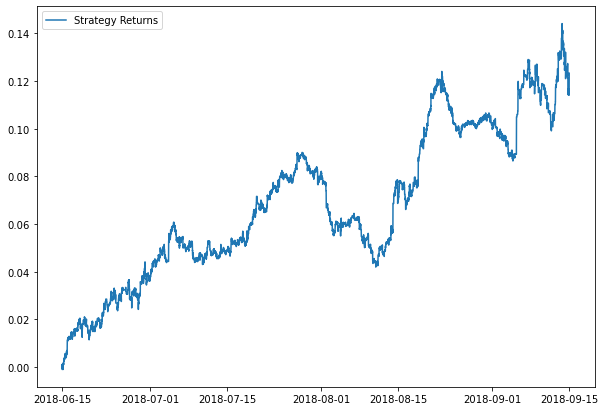

In [30]:
df1['Return'] = (df1.Open.shift(-1) - df1.Open) / df1.Open

# Calculate the strategy returns by multiplying the position with returns
# If you are 'long' then your returns will be the same as that of the market, hence a signal = 1
# If you are 'short' then your returns will be the opposite of the market, hence a signal = -1
df1['StrRet'] = df1.TradeSignal * df1.Return

# Plot the cumulative returns of the strategy
plt.figure(figsize=(10, 7))
plt.plot(df1.StrRet.cumsum())
plt.legend(['Strategy Returns'])
plt.show()